<a href="https://www.kaggle.com/code/mauddib/multilingual-chatbot-arena-0-61-lightgbm-classify?scriptVersionId=220840662" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Table of Contents

1. [Load data](#loaddata)
2. [Create and visualize some score features](#viz)
3. [Vectorize the prompt, response_a and response_b features](#select)
4. [Feature engineering](#clean)
5. [Train model](#load)
6. [Submission file](#get)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings("ignore")
from scipy.sparse import hstack 
from textblob import TextBlob
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import langid
from sklearn.metrics import roc_auc_score as ras
import string


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/wsdm-cup-multilingual-chatbot-arena/sample_submission.csv
/kaggle/input/wsdm-cup-multilingual-chatbot-arena/train.parquet
/kaggle/input/wsdm-cup-multilingual-chatbot-arena/test.parquet


# 1. Load data <a class="anchor"  id="loaddata"></a>

In [2]:
df_train = pd.read_parquet('/kaggle/input/wsdm-cup-multilingual-chatbot-arena/train.parquet', engine='pyarrow')
df_test = pd.read_parquet('/kaggle/input/wsdm-cup-multilingual-chatbot-arena/test.parquet', engine='pyarrow')

df_train.head(2)



,id,prompt,response_a,response_b,winner,model_a,model_b,language
0,00007cff95d7f7974642a785aca248b0f26e60d3312fac...,vieš po Slovensky?,"Áno, hovorím po slovensky. Ako vám môžem pomôcť?","Áno, veď som tu! Môžem ti pomôcť s otázkami al...",model_a,o1-preview,reka-core-20240904,Slovak
1,00010ed04b536f56ebe43eef1100c13906abea12bf9855...,You will be given a piece of news. Analyze it ...,Let's break down the news and analyze it accor...,"```json\n{\n ""contains_orgs"": true,\n ""orgs""...",model_a,gemma-2-27b-it,gemini-1.5-flash-002,Russian


# 2. Create and visualize some score features <a class="anchor"  id="viz"></a>

In [3]:
df_train['response_a'] = df_train['response_a'].apply(str.lower)
df_train['response_b'] = df_train['response_b'].apply(str.lower)
df_train['prompt'] = df_train['prompt'].apply(str.lower)

df_test['response_a'] = df_test['response_a'].apply(str.lower)
df_test['response_b'] = df_test['response_b'].apply(str.lower)
df_test['prompt'] = df_test['prompt'].apply(str.lower)

def count_spaces(text):
    count_s = text.count(' ')
    return count_s
    
df_train['space_count_a'] = df_train['response_a'].apply(count_spaces)+1
df_train['space_count_b'] = df_train['response_b'].apply(count_spaces)+1
df_test['space_count_a'] = df_test['response_a'].apply(count_spaces)+1
df_test['space_count_b'] = df_test['response_b'].apply(count_spaces)+1


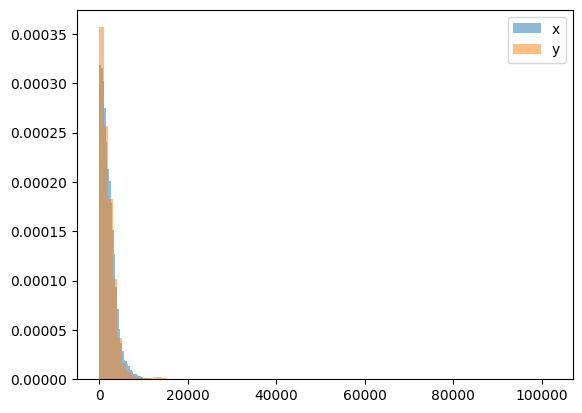

In [4]:
df_train['len_winner'] = np.where(df_train['winner']=='model_a',df_train['response_a'].str.len(),df_train['response_b'].str.len())
df_train['len_loser'] = np.where(df_train['winner']=='model_a',df_train['response_b'].str.len(),df_train['response_a'].str.len())
df_train['len_a'] = df_train['response_a'].str.len()
df_train['len_b'] = df_train['response_b'].str.len()

df_test['len_a'] = df_test['response_a'].str.len()
df_test['len_b'] = df_test['response_b'].str.len()

bins=100

plt.hist(df_train['len_winner'], bins, alpha=0.5, label='x', density=True)
plt.hist(df_train['len_loser'], bins, alpha=0.5, label='y', density=True)
plt.legend(loc='upper right')
plt.show()

(0.0, 35000.0)

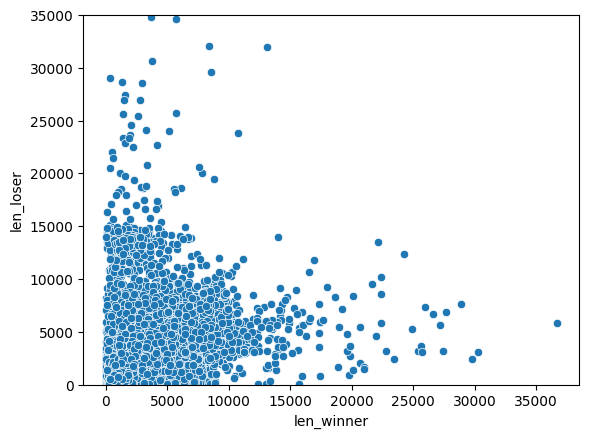

In [5]:
sns.scatterplot(x=df_train['len_winner'],y=df_train['len_loser'])
plt.ylim(0,35000)


(-1.0, 7.0)

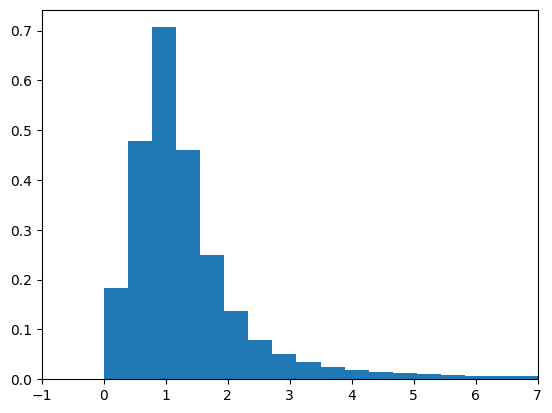

In [6]:
df_train['winner_len_ratio'] =df_train['len_winner']/df_train['len_loser']
df_train['response_a_ratio'] =df_train['len_a']/df_train['len_b']
df_train['response_b_ratio'] =df_train['len_b']/df_train['len_a']

df_test['response_a_ratio'] =df_test['len_a']/df_test['len_b']
df_test['response_b_ratio'] =df_test['len_b']/df_test['len_a']

plt.hist(df_train['winner_len_ratio'],bins=15000,density=True)
plt.xlim(-1,7)

In [7]:
df_train['winner_ind'] = np.where(df_train['winner']=='model_a',1,0)
df_train.head()

,id,prompt,response_a,response_b,winner,model_a,model_b,language,space_count_a,space_count_b,len_winner,len_loser,len_a,len_b,winner_len_ratio,response_a_ratio,response_b_ratio,winner_ind
0,00007cff95d7f7974642a785aca248b0f26e60d3312fac...,vieš po slovensky?,"áno, hovorím po slovensky. ako vám môžem pomôcť?","áno, veď som tu! môžem ti pomôcť s otázkami al...",model_a,o1-preview,reka-core-20240904,Slovak,8,36,48,194,48,194,0.247423,0.247423,4.041667,1
1,00010ed04b536f56ebe43eef1100c13906abea12bf9855...,you will be given a piece of news. analyze it ...,let's break down the news and analyze it accor...,"```json\n{\n ""contains_orgs"": true,\n ""orgs""...",model_a,gemma-2-27b-it,gemini-1.5-flash-002,Russian,195,29,1414,183,1414,183,7.726776,7.726776,0.129420,1
2,0003800d510e38803efba5ceaec122bc66408fe367b0be...,"dört basamaklı, rakamları birbirinden ve sıfır...","bu soruyu çözmek için, verilen koşulları adım ...",bu problemi adım adım çözelim:\n\n1) abcd - dc...,model_a,gpt-4-0125-preview,claude-3-5-sonnet-20240620,Turkish,304,186,2179,899,2179,899,2.423804,2.423804,0.412575,1
3,00072026c68f5418ef2da238394e418ce72a534b9b22d5...,"현재 추천된 탑 3 종목인 cabaletta bio (caba), rocket ph...","죄송하지만 저는 금융 조언을 제공할 수 없습니다. 저는 ai 모델이며, 투자 결정에...",현재 추천된 탑 3 종목에 순위를 매기기 위해서는 여러 가지 요소들을 고려해야 합니...,model_b,gemma-2-2b-it,llama-3.1-nemotron-70b-instruct,English,95,414,1799,477,477,1799,3.771488,0.265147,3.771488,0
4,0007ce7cf6bc1b5a8f8a4669b854fb12030863c970d9dc...,please be boring,"alright, i'll be as boring as possible.\n\ntod...","understood. here is a straightforward, unadorn...",model_a,reka-flash-20240722,grok-2-2024-08-13,English,229,52,1282,404,1282,404,3.173267,3.173267,0.315133,1


### Check class distribution

In [8]:
df_train['winner_ind'].value_counts(normalize=True)

winner_ind
0    0.505399
1    0.494601
Name: proportion, dtype: float64

# 3. Vectorize the prompt, response_a and response_b features <a class="anchor"  id="select"></a>

Term frequency Inverse document frequency (TFIDF) is a statistical formula to convert text documents into vectors based on the relevancy of the word. It is based on the bag of the words model to create a matrix containing the information about less relevant and most relevant words in the document. 

TF-IDF is particularly useful in NLP tasks, topic modeling, and machine learning tasks. It helps algorithms to use the importance of the words to predict outcomes.

In [9]:
# import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# ! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

In [10]:
# from textblob import TextBlob, Word

 
# def lemmatize(text):
#     lemmatized_sentence = " ".join([w.lemmatize() for w in TextBlob(text).words])
#     return lemmatized_sentence

In [11]:
# i seemed to get a better score without lemmatizing!

# df_train['response_a'] = df_train['response_a'].apply(lemmatize)
# df_train['response_b'] = df_train['response_b'].apply(lemmatize)
# df_train['prompt'] = df_train['prompt'].apply(lemmatize)

# df_test['response_a'] = df_test['response_a'].apply(lemmatize)
# df_test['response_b'] = df_test['response_b'].apply(lemmatize)
# df_test['prompt'] = df_test['prompt'].apply(lemmatize)

In [12]:
vectorizer_char = TfidfVectorizer(sublinear_tf=True, analyzer='char', ngram_range=(1,2), max_features=100_000)
vectorizer_word = TfidfVectorizer(sublinear_tf=True, analyzer='word', min_df=3)
preprocessor = ColumnTransformer(
    transformers=[
        ('prompt_feats', FeatureUnion([
            ('prompt_char', vectorizer_char),
            ('prompt_word', vectorizer_word)
        ]), 'prompt'),
        ('response_a_feats', FeatureUnion([
            ('response_a_char', vectorizer_char),
            ('response_a_word', vectorizer_word)
        ]), 'response_a'),
        ('response_b_feats', FeatureUnion([
            ('response_b_char', vectorizer_char),
            ('response_b_word', vectorizer_word)
        ]), 'response_b')
    ]
)

Now here we split the df_train data into training and validation sets, based on the index of the dataframe, specifically so that we can append extra features to the sparse matrix later. Stratification ensures class balance across the sets.

In [13]:
idx_train, idx_validation = train_test_split(df_train.index,test_size=0.20,stratify=df_train["winner_ind"], random_state=42)
X_train, y_train = df_train.loc[idx_train,["response_a","response_b","prompt"]],  df_train.loc[idx_train, 'winner_ind']
X_val, y_val = df_train.loc[idx_validation,["response_a","response_b","prompt"]],  df_train.loc[idx_validation, 'winner_ind']

In [14]:
print(df_train.shape)
print(X_train.shape)
print(X_val.shape)

(48439, 18)
(38751, 3)
(9688, 3)


Apply to the data:

In [15]:
train_feats = preprocessor.fit_transform(X_train)
val_feats = preprocessor.transform(X_val)
test_feats = preprocessor.transform(df_test[["response_a","response_b","prompt"]])

In text analysis, cosine similarity is used to measure the similarity between document vectors, where each document is represented as a vector in a high-dimensional space, with each dimension corresponding to a term or word in the corpus.

In [16]:

def add_cosine_similarity_feature(df, feature1, feature2, new_feature_name):
    def compute_cosine_similarity(row):
        try:
            if not row[feature1] or not row[feature2]:
                return 0.0
            
            vectorizer = TfidfVectorizer(stop_words='english')
            tfidf_matrix = vectorizer.fit_transform([row[feature1], row[feature2]])
            
            return cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
        except:
            return 0
    
    df[new_feature_name] = df.progress_apply(compute_cosine_similarity, axis=1)
    return df

In [17]:
train = add_cosine_similarity_feature(df_train, 'prompt', 'response_a', 'response_a_similarity')
train = add_cosine_similarity_feature(df_train, 'prompt', 'response_b', 'response_b_similarity')

100%|██████████| 48439/48439 [02:10<00:00, 369.80it/s]


In [18]:
test = add_cosine_similarity_feature(df_test, 'prompt', 'response_a', 'response_a_similarity')
test = add_cosine_similarity_feature(df_test, 'prompt', 'response_b', 'response_b_similarity')

100%|██████████| 3/3 [00:00<00:00, 314.77it/s]


density scatter of the two similarities, if nothing else it looks cool! Actually it reflects the fact that there are lots of response pairs that differ from one another ito how similar they are to their prompt.

<Axes: xlabel='response_a_similarity', ylabel='response_b_similarity'>

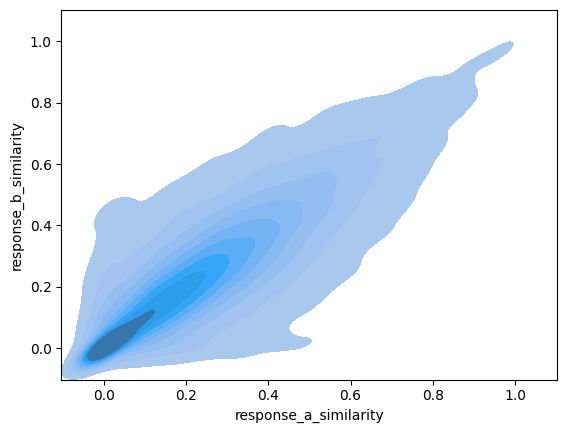

In [19]:
sns.kdeplot(
    data=df_train, x="response_a_similarity", y="response_b_similarity", fill=True,
)

# 4. Continued feature engineering <a class="anchor"  id="clean"></a>

Craft a similarity score

In [20]:
df_train['response_a_similarity_ratio'] = df_train['response_a_similarity']-(df_train['response_b_similarity'])
df_test['response_a_similarity_ratio'] = df_test['response_a_similarity']-df_test['response_b_similarity']
df_train['response_b_similarity_ratio'] = df_train['response_b_similarity']-df_train['response_a_similarity']
df_test['response_b_similarity_ratio'] = df_test['response_b_similarity']-df_test['response_a_similarity']

df_train.columns

Index(['id', 'prompt', 'response_a', 'response_b', 'winner', 'model_a',
       'model_b', 'language', 'space_count_a', 'space_count_b', 'len_winner',
       'len_loser', 'len_a', 'len_b', 'winner_len_ratio', 'response_a_ratio',
       'response_b_ratio', 'winner_ind', 'response_a_similarity',
       'response_b_similarity', 'response_a_similarity_ratio',
       'response_b_similarity_ratio'],
      dtype='object')

In [21]:
X_train_response_a_simrat = df_train.loc[idx_train,"response_a_similarity_ratio"]
X_val_response_a_simrat = df_train.loc[idx_validation,"response_a_similarity_ratio"]

(0.0, 1.0)

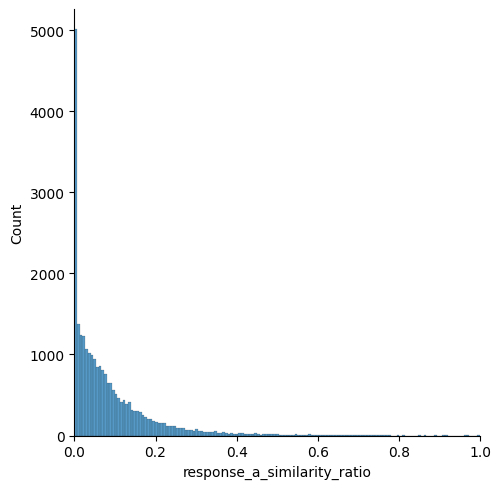

In [22]:
sns.displot( x=df_train['response_a_similarity_ratio'])
plt.xlim(0,1)

In [23]:
df_train['response_a_similarity_ratio'].describe()

count    48439.000000
mean         0.000055
std          0.145510
min         -1.000000
25%         -0.060539
50%          0.000000
75%          0.060223
max          1.000000
Name: response_a_similarity_ratio, dtype: float64

In [24]:
X_train_all_features = hstack([train_feats, df_train.loc[idx_train, 'response_a_similarity_ratio'].values.reshape(-1, 1)]) 
X_train_all_features.shape

(38751, 620008)

In [25]:
X_val_all_features = hstack([val_feats, df_train.loc[idx_validation, 'response_a_similarity_ratio'].values.reshape(-1, 1)]) 
X_val_all_features.shape

(9688, 620008)

In [26]:
X_test_all_features = hstack([test_feats, df_test['response_a_similarity_ratio'].values.reshape(-1, 1)]) 
X_test_all_features.shape

(3, 620008)

Calculate polarity (conventional and vader) and subjectivity as features, apply to all sets of data:

In [27]:
def sentiment_calc(text):
    try:
        return TextBlob(text).sentiment
    except:
        return 0.0

df_train[['polarity_a', 'subjectivity_a']] = df_train['response_a'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
df_train[['polarity_b', 'subjectivity_b']] = df_train['response_b'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
df_train[['polarity_prompt', 'subjectivity_prompt']] = df_train['prompt'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
df_test[['polarity_a', 'subjectivity_a']] = df_test['response_a'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
df_test[['polarity_b', 'subjectivity_b']] = df_test['response_b'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
df_test[['polarity_prompt', 'subjectivity_prompt']] = df_test['prompt'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

df_train['polarity_a_score'] = df_train['polarity_prompt'] - df_train['polarity_a']
df_train['polarity_b_score'] = df_train['polarity_prompt'] - df_train['polarity_b']
df_test['polarity_a_score'] = df_test['polarity_prompt'] - df_test['polarity_a']
df_test['polarity_b_score'] = df_test['polarity_prompt'] - df_test['polarity_b']

In [28]:
df_train['subjectivity_a_score'] = df_train['subjectivity_prompt'] - df_train['subjectivity_a']
df_train['subjectivity_b_score'] = df_train['subjectivity_prompt'] - df_train['subjectivity_b']
df_test['subjectivity_a_score'] = df_test['subjectivity_prompt'] - df_test['subjectivity_a']
df_test['subjectivity_b_score'] = df_test['subjectivity_prompt'] - df_test['subjectivity_b']

df_train['subjectivity_score'] = df_train['subjectivity_a_score'] - df_train['subjectivity_b_score']
df_test['subjectivity_score'] = df_test['subjectivity_a_score'] - df_test['subjectivity_b_score']

In [29]:
sent = SentimentIntensityAnalyzer()

polarity = [round(sent.polarity_scores(i)['compound'], 2) for i in df_train['response_a']]
df_train['sentiment_score_a'] = polarity
polarity = [round(sent.polarity_scores(i)['compound'], 2) for i in df_train['response_b']]
df_train['sentiment_score_b'] = polarity
polarity = [round(sent.polarity_scores(i)['compound'], 2) for i in df_train['prompt']]
df_train['sentiment_score_prompt'] = polarity

In [30]:
polarity = [round(sent.polarity_scores(i)['compound'], 2) for i in df_test['response_a']]
df_test['sentiment_score_a'] = polarity
polarity = [round(sent.polarity_scores(i)['compound'], 2) for i in df_test['response_b']]
df_test['sentiment_score_b'] = polarity
polarity = [round(sent.polarity_scores(i)['compound'], 2) for i in df_test['prompt']]
df_test['sentiment_score_prompt'] = polarity

In [31]:
df_train['v_polarity_a_score'] = df_train['sentiment_score_prompt'] - df_train['sentiment_score_a']
df_train['v_polarity_b_score'] = df_train['sentiment_score_prompt'] - df_train['sentiment_score_b']
df_test['v_polarity_a_score'] = df_test['sentiment_score_prompt'] - df_test['sentiment_score_a']
df_test['v_polarity_b_score'] = df_test['sentiment_score_prompt'] - df_test['sentiment_score_b']

Hmmm lets see just how correlated our features are relative to the response variable:

In [32]:
corr = pd.DataFrame(df_train[['len_a','len_b','winner_len_ratio','response_a_ratio','response_b_ratio'
           ,'response_a_similarity','response_b_similarity','response_a_similarity_ratio',
           'response_b_similarity_ratio','sentiment_score_b','sentiment_score_a','polarity_a',
           'subjectivity_a','polarity_b', 'subjectivity_b','v_polarity_a_score',
                              'v_polarity_b_score','polarity_a_score','polarity_b_score'
                              ,'subjectivity_a_score','subjectivity_b_score','subjectivity_score']].corrwith(df_train['winner_ind'])).reset_index()

<BarContainer object of 22 artists>

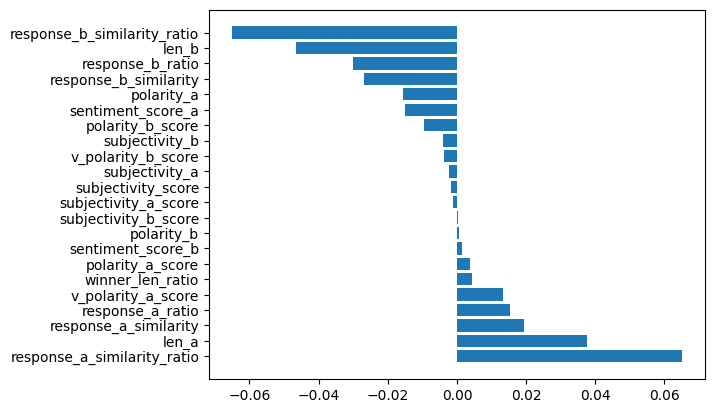

In [33]:
corr.columns = ['item','corr']
corr = corr.sort_values(by=['corr'],ascending = False)
plt.barh(corr['item'],corr['corr'])

Hmmmm lets create a few more still, this time based on the language

In [34]:
def langdetector(text):
    return langid.classify(text)[0]

def isEnglish(s):
  return s.isascii()

In [35]:
df_test['isEnglish'] = df_test['response_a'].apply(isEnglish)

In [36]:
df_train['lang_'] = df_train['prompt'].apply(langdetector)
df_train['isEnglish'] = df_train['response_a'].apply(isEnglish)
df_train.head()

,id,prompt,response_a,response_b,winner,model_a,model_b,language,space_count_a,space_count_b,...,subjectivity_a_score,subjectivity_b_score,subjectivity_score,sentiment_score_a,sentiment_score_b,sentiment_score_prompt,v_polarity_a_score,v_polarity_b_score,lang_,isEnglish
0,00007cff95d7f7974642a785aca248b0f26e60d3312fac...,vieš po slovensky?,"áno, hovorím po slovensky. ako vám môžem pomôcť?","áno, veď som tu! môžem ti pomôcť s otázkami al...",model_a,o1-preview,reka-core-20240904,Slovak,8,36,...,0.000000,0.000000,0.000000,-0.56,0.56,-0.56,0.00,-1.12,sl,False
1,00010ed04b536f56ebe43eef1100c13906abea12bf9855...,you will be given a piece of news. analyze it ...,let's break down the news and analyze it accor...,"```json\n{\n ""contains_orgs"": true,\n ""orgs""...",model_a,gemma-2-27b-it,gemini-1.5-flash-002,Russian,195,29,...,0.046321,-0.111375,0.157696,0.66,0.42,-0.62,-1.28,-1.04,ru,False
2,0003800d510e38803efba5ceaec122bc66408fe367b0be...,"dört basamaklı, rakamları birbirinden ve sıfır...","bu soruyu çözmek için, verilen koşulları adım ...",bu problemi adım adım çözelim:\n\n1) abcd - dc...,model_a,gpt-4-0125-preview,claude-3-5-sonnet-20240620,Turkish,304,186,...,-1.000000,-1.000000,0.000000,0.00,0.44,0.00,0.00,-0.44,tr,False
3,00072026c68f5418ef2da238394e418ce72a534b9b22d5...,"현재 추천된 탑 3 종목인 cabaletta bio (caba), rocket ph...","죄송하지만 저는 금융 조언을 제공할 수 없습니다. 저는 ai 모델이며, 투자 결정에...",현재 추천된 탑 3 종목에 순위를 매기기 위해서는 여러 가지 요소들을 고려해야 합니...,model_b,gemma-2-2b-it,llama-3.1-nemotron-70b-instruct,English,95,414,...,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,ko,False
4,0007ce7cf6bc1b5a8f8a4669b854fb12030863c970d9dc...,please be boring,"alright, i'll be as boring as possible.\n\ntod...","understood. here is a straightforward, unadorn...",model_a,reka-flash-20240722,grok-2-2024-08-13,English,229,52,...,0.671334,0.406944,0.264390,0.59,0.36,0.00,-0.59,-0.36,en,True


In [37]:
print(df_train['lang_'].value_counts().head(10))

lang_
en    23467
ru     7220
zh     4782
vi     3156
de     1489
ja     1215
ko     1189
es      949
fr      791
pt      570
Name: count, dtype: int64


<Axes: xlabel='isEnglish'>

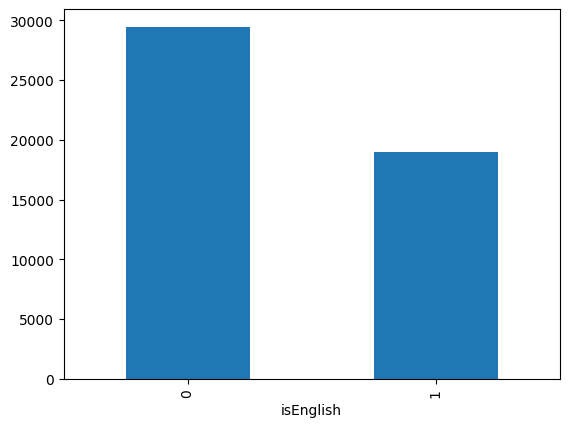

In [38]:
df_train["isEnglish"] = df_train["isEnglish"].astype(int)
df_train['isEnglish'].value_counts().plot(kind='bar')

In [39]:
df_train = pd.get_dummies(df_train,columns = ['lang_'], dtype= int) 

In [40]:
df_test['lang_'] = df_test['prompt'].apply(langdetector)
df_test = pd.get_dummies(df_test,columns = ['lang_'], dtype= int)

In [41]:
cols = df_train.columns.union(df_test.columns)
df_test = df_test.reindex(cols, axis=1, fill_value=0)

Now we add the features to the sparse matrices at the end on the right of each one, for all sets:

In [42]:
df_train.head()

,id,prompt,response_a,response_b,winner,model_a,model_b,language,space_count_a,space_count_b,...,lang__tl,lang__tr,lang__uk,lang__ur,lang__vi,lang__vo,lang__wa,lang__xh,lang__zh,lang__zu
0,00007cff95d7f7974642a785aca248b0f26e60d3312fac...,vieš po slovensky?,"áno, hovorím po slovensky. ako vám môžem pomôcť?","áno, veď som tu! môžem ti pomôcť s otázkami al...",model_a,o1-preview,reka-core-20240904,Slovak,8,36,...,0,0,0,0,0,0,0,0,0,0
1,00010ed04b536f56ebe43eef1100c13906abea12bf9855...,you will be given a piece of news. analyze it ...,let's break down the news and analyze it accor...,"```json\n{\n ""contains_orgs"": true,\n ""orgs""...",model_a,gemma-2-27b-it,gemini-1.5-flash-002,Russian,195,29,...,0,0,0,0,0,0,0,0,0,0
2,0003800d510e38803efba5ceaec122bc66408fe367b0be...,"dört basamaklı, rakamları birbirinden ve sıfır...","bu soruyu çözmek için, verilen koşulları adım ...",bu problemi adım adım çözelim:\n\n1) abcd - dc...,model_a,gpt-4-0125-preview,claude-3-5-sonnet-20240620,Turkish,304,186,...,0,1,0,0,0,0,0,0,0,0
3,00072026c68f5418ef2da238394e418ce72a534b9b22d5...,"현재 추천된 탑 3 종목인 cabaletta bio (caba), rocket ph...","죄송하지만 저는 금융 조언을 제공할 수 없습니다. 저는 ai 모델이며, 투자 결정에...",현재 추천된 탑 3 종목에 순위를 매기기 위해서는 여러 가지 요소들을 고려해야 합니...,model_b,gemma-2-2b-it,llama-3.1-nemotron-70b-instruct,English,95,414,...,0,0,0,0,0,0,0,0,0,0
4,0007ce7cf6bc1b5a8f8a4669b854fb12030863c970d9dc...,please be boring,"alright, i'll be as boring as possible.\n\ntod...","understood. here is a straightforward, unadorn...",model_a,reka-flash-20240722,grok-2-2024-08-13,English,229,52,...,0,0,0,0,0,0,0,0,0,0


Top 10 Language features:

In [43]:
# en    23467
# ru     7220
# zh     4782
# vi     3156
# de     1489
# ja     1215
# ko     1189
# es      949
# fr      791
# pt      570

X_train_all_features = hstack([X_train_all_features, df_train.loc[idx_train, 'lang__en'].values.reshape(-1, 1)])
X_val_all_features = hstack([X_val_all_features, df_train.loc[idx_validation, 'lang__en'].values.reshape(-1, 1)])
X_test_all_features = hstack([X_test_all_features, df_test['lang__en'].values.reshape(-1, 1)])

X_train_all_features = hstack([X_train_all_features, df_train.loc[idx_train, 'lang__ru'].values.reshape(-1, 1)])
X_val_all_features = hstack([X_val_all_features, df_train.loc[idx_validation, 'lang__ru'].values.reshape(-1, 1)])
X_test_all_features = hstack([X_test_all_features, df_test['lang__ru'].values.reshape(-1, 1)])

X_train_all_features = hstack([X_train_all_features, df_train.loc[idx_train, 'lang__zh'].values.reshape(-1, 1)])
X_val_all_features = hstack([X_val_all_features, df_train.loc[idx_validation, 'lang__zh'].values.reshape(-1, 1)])
X_test_all_features = hstack([X_test_all_features, df_test['lang__zh'].values.reshape(-1, 1)])

X_train_all_features = hstack([X_train_all_features, df_train.loc[idx_train, 'lang__vi'].values.reshape(-1, 1)])
X_val_all_features = hstack([X_val_all_features, df_train.loc[idx_validation, 'lang__vi'].values.reshape(-1, 1)])
X_test_all_features = hstack([X_test_all_features, df_test['lang__vi'].values.reshape(-1, 1)])

X_train_all_features = hstack([X_train_all_features, df_train.loc[idx_train, 'lang__de'].values.reshape(-1, 1)])
X_val_all_features = hstack([X_val_all_features, df_train.loc[idx_validation, 'lang__de'].values.reshape(-1, 1)])
X_test_all_features = hstack([X_test_all_features, df_test['lang__de'].values.reshape(-1, 1)])

X_train_all_features = hstack([X_train_all_features, df_train.loc[idx_train, 'lang__ja'].values.reshape(-1, 1)])
X_val_all_features = hstack([X_val_all_features, df_train.loc[idx_validation, 'lang__ja'].values.reshape(-1, 1)])
X_test_all_features = hstack([X_test_all_features, df_test['lang__ja'].values.reshape(-1, 1)])

X_train_all_features = hstack([X_train_all_features, df_train.loc[idx_train, 'lang__ko'].values.reshape(-1, 1)])
X_val_all_features = hstack([X_val_all_features, df_train.loc[idx_validation, 'lang__ko'].values.reshape(-1, 1)])
X_test_all_features = hstack([X_test_all_features, df_test['lang__ko'].values.reshape(-1, 1)])

X_train_all_features = hstack([X_train_all_features, df_train.loc[idx_train, 'lang__es'].values.reshape(-1, 1)])
X_val_all_features = hstack([X_val_all_features, df_train.loc[idx_validation, 'lang__es'].values.reshape(-1, 1)])
X_test_all_features = hstack([X_test_all_features, df_test['lang__es'].values.reshape(-1, 1)])

X_train_all_features = hstack([X_train_all_features, df_train.loc[idx_train, 'lang__fr'].values.reshape(-1, 1)])
X_val_all_features = hstack([X_val_all_features, df_train.loc[idx_validation, 'lang__fr'].values.reshape(-1, 1)])
X_test_all_features = hstack([X_test_all_features, df_test['lang__fr'].values.reshape(-1, 1)])

X_train_all_features = hstack([X_train_all_features, df_train.loc[idx_train, 'lang__pt'].values.reshape(-1, 1)])
X_val_all_features = hstack([X_val_all_features, df_train.loc[idx_validation, 'lang__pt'].values.reshape(-1, 1)])
X_test_all_features = hstack([X_test_all_features, df_test['lang__pt'].values.reshape(-1, 1)])

Add the other features too:

In [44]:
X_train_all_features = hstack([X_train_all_features, df_train.loc[idx_train, 'polarity_a'].values.reshape(-1, 1)])
X_val_all_features = hstack([X_val_all_features, df_train.loc[idx_validation, 'polarity_a'].values.reshape(-1, 1)])
X_test_all_features = hstack([X_test_all_features, df_test['polarity_a'].values.reshape(-1, 1)])

In [45]:
X_train_all_features = hstack([X_train_all_features, df_train.loc[idx_train, 'subjectivity_a'].values.reshape(-1, 1)])
X_val_all_features = hstack([X_val_all_features, df_train.loc[idx_validation, 'subjectivity_a'].values.reshape(-1, 1)])
X_test_all_features = hstack([X_test_all_features, df_test['subjectivity_a'].values.reshape(-1, 1)])

In [46]:
X_train_all_features = hstack([X_train_all_features, df_train.loc[idx_train, 'subjectivity_score'].values.reshape(-1, 1)])
X_val_all_features = hstack([X_val_all_features, df_train.loc[idx_validation, 'subjectivity_score'].values.reshape(-1, 1)])
X_test_all_features = hstack([X_test_all_features, df_test['subjectivity_score'].values.reshape(-1, 1)])

In [47]:
X_train_all_features = hstack([X_train_all_features, df_train.loc[idx_train, 'sentiment_score_a'].values.reshape(-1, 1)])
X_val_all_features = hstack([X_val_all_features, df_train.loc[idx_validation, 'sentiment_score_a'].values.reshape(-1, 1)])
X_test_all_features = hstack([X_test_all_features, df_test['sentiment_score_a'].values.reshape(-1, 1)])

In [48]:
X_train_all_features = hstack([X_train_all_features, df_train.loc[idx_train, 'isEnglish'].values.reshape(-1, 1)])
X_val_all_features = hstack([X_val_all_features, df_train.loc[idx_validation, 'isEnglish'].values.reshape(-1, 1)])
X_test_all_features = hstack([X_test_all_features, df_test['isEnglish'].values.reshape(-1, 1)])

In [49]:
X_train_all_features = hstack([X_train_all_features, df_train.loc[idx_train, 'polarity_b'].values.reshape(-1, 1)])
X_val_all_features = hstack([X_val_all_features, df_train.loc[idx_validation, 'polarity_b'].values.reshape(-1, 1)])
X_test_all_features = hstack([X_test_all_features, df_test['polarity_b'].values.reshape(-1, 1)])

In [50]:
X_train_all_features = hstack([X_train_all_features, df_train.loc[idx_train, 'subjectivity_b'].values.reshape(-1, 1)])
X_val_all_features = hstack([X_val_all_features, df_train.loc[idx_validation, 'subjectivity_b'].values.reshape(-1, 1)])
X_test_all_features = hstack([X_test_all_features, df_test['subjectivity_b'].values.reshape(-1, 1)])

In [51]:
X_train_all_features = hstack([X_train_all_features, df_train.loc[idx_train, 'sentiment_score_b'].values.reshape(-1, 1)])
X_val_all_features = hstack([X_val_all_features, df_train.loc[idx_validation, 'sentiment_score_b'].values.reshape(-1, 1)])
X_test_all_features = hstack([X_test_all_features, df_test['sentiment_score_b'].values.reshape(-1, 1)])

In [52]:
X_train_all_features = hstack([X_train_all_features, df_train.loc[idx_train, 'len_b'].values.reshape(-1, 1)])
X_val_all_features = hstack([X_val_all_features, df_train.loc[idx_validation, 'len_b'].values.reshape(-1, 1)])
X_test_all_features = hstack([X_test_all_features, df_test['len_b'].values.reshape(-1, 1)])

In [53]:
X_train_all_features = hstack([X_train_all_features, df_train.loc[idx_train, 'len_a'].values.reshape(-1, 1)])
X_val_all_features = hstack([X_val_all_features, df_train.loc[idx_validation, 'len_a'].values.reshape(-1, 1)])
X_test_all_features = hstack([X_test_all_features, df_test['len_a'].values.reshape(-1, 1)])

In [54]:
X_train_all_features = hstack([X_train_all_features, df_train.loc[idx_train, 'v_polarity_a_score'].values.reshape(-1, 1)])
X_val_all_features = hstack([X_val_all_features, df_train.loc[idx_validation, 'v_polarity_a_score'].values.reshape(-1, 1)])
X_test_all_features = hstack([X_test_all_features, df_test['v_polarity_a_score'].values.reshape(-1, 1)])

In [55]:
X_train_all_features = hstack([X_train_all_features, df_train.loc[idx_train, 'v_polarity_b_score'].values.reshape(-1, 1)])
X_val_all_features = hstack([X_val_all_features, df_train.loc[idx_validation, 'v_polarity_b_score'].values.reshape(-1, 1)])
X_test_all_features = hstack([X_test_all_features, df_test['v_polarity_b_score'].values.reshape(-1, 1)])

In [56]:
X_train_all_features = hstack([X_train_all_features, df_train.loc[idx_train, 'polarity_a_score'].values.reshape(-1, 1)])
X_val_all_features = hstack([X_val_all_features, df_train.loc[idx_validation, 'polarity_a_score'].values.reshape(-1, 1)])
X_test_all_features = hstack([X_test_all_features, df_test['polarity_a_score'].values.reshape(-1, 1)])

In [57]:
X_train_all_features = hstack([X_train_all_features, df_train.loc[idx_train, 'polarity_b_score'].values.reshape(-1, 1)])
X_val_all_features = hstack([X_val_all_features, df_train.loc[idx_validation, 'polarity_b_score'].values.reshape(-1, 1)])
X_test_all_features = hstack([X_test_all_features, df_test['polarity_b_score'].values.reshape(-1, 1)])

Try creating another feature:
Here we will calculate the punctuation prevalence:

In [58]:
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

df_train['punct%'] = df_train['response_a'].apply(lambda x: count_punct(x))

df_train.head(2)

,id,prompt,response_a,response_b,winner,model_a,model_b,language,space_count_a,space_count_b,...,lang__tr,lang__uk,lang__ur,lang__vi,lang__vo,lang__wa,lang__xh,lang__zh,lang__zu,punct%
0,00007cff95d7f7974642a785aca248b0f26e60d3312fac...,vieš po slovensky?,"áno, hovorím po slovensky. ako vám môžem pomôcť?","áno, veď som tu! môžem ti pomôcť s otázkami al...",model_a,o1-preview,reka-core-20240904,Slovak,8,36,...,0,0,0,0,0,0,0,0,0,7.3
1,00010ed04b536f56ebe43eef1100c13906abea12bf9855...,you will be given a piece of news. analyze it ...,let's break down the news and analyze it accor...,"```json\n{\n ""contains_orgs"": true,\n ""orgs""...",model_a,gemma-2-27b-it,gemini-1.5-flash-002,Russian,195,29,...,0,0,0,0,0,0,0,0,0,7.7


In [59]:
df_test['punct%'] = df_test['response_a'].apply(lambda x: count_punct(x))

In [60]:
df_train['len_a_diff'] = df_train['len_a'] - df_train['len_b']
df_test['len_a_diff'] = df_test['len_a'] - df_test['len_b']

OK lets check correlation to response a final time:

In [61]:
df_train["response_a_prompt_overlap"] = df_train.apply(lambda x: len(set(x["prompt"].split()).intersection(set(x["response_a"].split()))) / len(set(x["prompt"].split())) if len(set(x["prompt"].split())) > 0 else 0, axis=1)
df_train["response_b_prompt_overlap"] = df_train.apply(lambda x: len(set(x["prompt"].split()).intersection(set(x["response_b"].split()))) / len(set(x["prompt"].split())) if len(set(x["prompt"].split())) > 0 else 0, axis=1)
df_train["prompt_overlap_score"] = df_train["response_a_prompt_overlap"]-df_train["response_b_prompt_overlap"]

In [62]:
df_train["prompt_overlap_score2"] = df_train["response_a_prompt_overlap"]/len(df_train["response_a"])

In [63]:
df_test["response_a_prompt_overlap"] = df_test.apply(lambda x: len(set(x["prompt"].split()).intersection(set(x["response_a"].split()))) / len(set(x["prompt"].split())) if len(set(x["prompt"].split())) > 0 else 0, axis=1)
df_test["response_b_prompt_overlap"] = df_test.apply(lambda x: len(set(x["prompt"].split()).intersection(set(x["response_b"].split()))) / len(set(x["prompt"].split())) if len(set(x["prompt"].split())) > 0 else 0, axis=1)
df_test["prompt_overlap_score"] = df_test["response_a_prompt_overlap"]-df_test["response_b_prompt_overlap"]

In [64]:
corr = pd.DataFrame(df_train[['len_a','len_b','winner_len_ratio','response_a_ratio','response_b_ratio'
           ,'response_a_similarity','response_b_similarity','response_a_similarity_ratio',
           'response_b_similarity_ratio','sentiment_score_b','sentiment_score_a','polarity_a',
           'subjectivity_a','polarity_b', 'subjectivity_b','isEnglish','punct%',
            'len_a_diff','space_count_a','space_count_b','v_polarity_a_score',
            'v_polarity_b_score','polarity_a_score','polarity_b_score','prompt_overlap_score','prompt_overlap_score2']].corrwith(df_train['winner_ind'])).reset_index()

<BarContainer object of 26 artists>

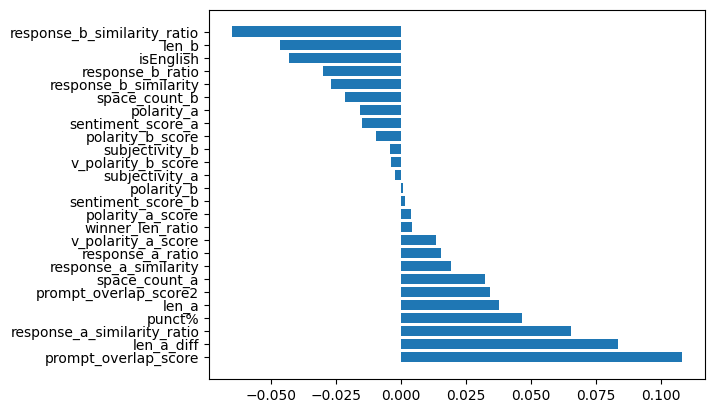

In [65]:
corr.columns = ['item','corr']
corr = corr.sort_values(by=['corr'],ascending = False)
plt.barh(corr['item'],corr['corr'])

Well from the above you can see the basic feature of length a - length b is the strongest variable on its own. Lets add the latest features to the sparse matrices and train a model!

In [66]:
X_train_all_features = hstack([X_train_all_features, df_train.loc[idx_train, 'prompt_overlap_score'].values.reshape(-1, 1)])
X_val_all_features = hstack([X_val_all_features, df_train.loc[idx_validation, 'prompt_overlap_score'].values.reshape(-1, 1)])
X_test_all_features = hstack([X_test_all_features, df_test['prompt_overlap_score'].values.reshape(-1, 1)])

In [67]:
X_train_all_features = hstack([X_train_all_features, df_train.loc[idx_train, 'punct%'].values.reshape(-1, 1)])
X_val_all_features = hstack([X_val_all_features, df_train.loc[idx_validation, 'punct%'].values.reshape(-1, 1)])
X_test_all_features = hstack([X_test_all_features, df_test['punct%'].values.reshape(-1, 1)])

In [68]:
X_train_all_features = hstack([X_train_all_features, df_train.loc[idx_train, 'len_a_diff'].values.reshape(-1, 1)])
X_val_all_features = hstack([X_val_all_features, df_train.loc[idx_validation, 'len_a_diff'].values.reshape(-1, 1)])
X_test_all_features = hstack([X_test_all_features, df_test['len_a_diff'].values.reshape(-1, 1)])

In [69]:
X_train_all_features = hstack([X_train_all_features, df_train.loc[idx_train, 'space_count_a'].values.reshape(-1, 1)])
X_val_all_features = hstack([X_val_all_features, df_train.loc[idx_validation, 'space_count_a'].values.reshape(-1, 1)])
X_test_all_features = hstack([X_test_all_features, df_test['space_count_a'].values.reshape(-1, 1)])

In [70]:
X_train_all_features = hstack([X_train_all_features, df_train.loc[idx_train, 'space_count_b'].values.reshape(-1, 1)])
X_val_all_features = hstack([X_val_all_features, df_train.loc[idx_validation, 'space_count_b'].values.reshape(-1, 1)])
X_test_all_features = hstack([X_test_all_features, df_test['space_count_b'].values.reshape(-1, 1)])

# 5. Train model <a class="anchor"  id="load"></a>

Hello magic black box:

In [71]:
num_round = 30
# Create LightGBM Dataset for training and validation
train_data = lgb.Dataset(X_train_all_features, label=y_train)
test_data = lgb.Dataset(X_val_all_features, label=y_val, reference=train_data)

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'device_type':'gpu',
    'max_depth':7,
    'metric': 'auc',
    'num_leaves': 35,
    'learning_rate': 0.05,
    'feature_fraction': 0.4,#change from 0.4 to 0.6
    'bagging_fraction': 0.35, #change from 0.35 to 0.7 ihere
    'bagging_freq': 2,
    'verbose': 1,
    'lambda_l1':0.5,
    'lambda_l2':0.9,
    'min_data_in_leaf': 20,
    'max_bin': 200,
    'min_data_in_bin':20 
}

# Train a LightGBM model using defined parameters, training data, and specified number of rounds
model = lgb.train(params, train_data,
                  num_round, valid_sets=[test_data])

[LightGBM] [Info] Number of positive: 19166, number of negative: 19585
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1712350
[LightGBM] [Info] Number of data points in the train set: 38751, number of used features: 138758
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 592 dense feature groups (21.88 MB) transferred to GPU in 0.013264 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494594 -> initscore=-0.021626
[LightGBM] [Info] Start training from score -0.021626


Model performance:

In [72]:
print(ras(y_train, model.predict(X_train_all_features)))
print(ras(y_val, model.predict(X_val_all_features)))

0.7106100055223419
0.6582519493955067


So from the above we can see a little bit of overfitting, be careful!

#### Plot the confusion matrix:

In [73]:
y_val_pred = np.where(model.predict(X_val_all_features) > 0.5,1,0)
cm_labels = np.unique(y_val)
cm_array = confusion_matrix(y_val.astype(int), y_val_pred)
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)

<Axes: >

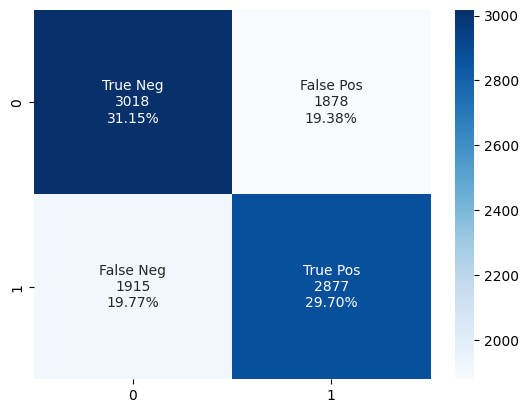

In [74]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm_array.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm_array.flatten()/np.sum(cm_array)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_array, annot=labels, fmt='', cmap='Blues')

In [75]:

df_test["winner"] = model.predict(X_test_all_features)
df_test.head(2)

,id,isEnglish,lang__af,lang__am,lang__an,lang__ar,lang__as,lang__az,lang__be,lang__bg,...,v_polarity_a_score,v_polarity_b_score,winner,winner_ind,winner_len_ratio,punct%,len_a_diff,response_a_prompt_overlap,response_b_prompt_overlap,prompt_overlap_score
0,327228,False,0,0,0,0,0,0,0,0,...,-0.13,-0.43,0.401079,0,0,5.1,-1451,0.570000,0.39,0.180000
1,1139415,True,0,0,0,0,0,0,0,0,...,0.04,0.45,0.498049,0,0,5.8,62,0.444444,0.50,-0.055556


# 6. Submission file <a class="anchor"  id="get"></a>

In [76]:
df_test["winner"]=df_test["winner"].apply(lambda x: "model_a" if x>0.5 else "model_b")

sub=df_test[["id","winner"]]

In [77]:
sub.head()

,id,winner
0,327228,model_b
1,1139415,model_b
2,1235630,model_a


In [78]:
sub.to_csv("/kaggle/working/submission.csv",index=False)